In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
l = 0.2
sigma = 2
rbf_kcreate = lambda l, sigma: lambda x,y: (sigma**2)*np.exp( -((x - y)**2)/(2*l**2)  )
rbf_kernel = rbf_kcreate(l, sigma)

In [11]:
sigma = 0.13 # variance
l = 3.5 # length
p = 0.27 # periodicity
periodic_kcreate = lambda sigma, l, p: lambda x,y: (sigma**2)*np.exp( -2*(np.sin(np.pi*np.abs(x-y)/p)**2)/(l**2)  )
periodic_kernel = periodic_kcreate(sigma, l, p)

In [12]:
sigma = 0.83
sigma_b = 0.85
c = 3
linear_kcreate = lambda sigma, sigma_b, c: lambda x, y: sigma_b**2 + (sigma**2)*(x-c)*(y-c)
linear_kernel = linear_kcreate(sigma, sigma_b, c)

In [13]:
# kernel = rbf_kernel
# kernel = periodic_kernel
kernel = linear_kernel

# composite
kernel = lambda x, y: 0.7*rbf_kernel(x,y) + 0.3*periodic_kernel(x, y)

In [14]:
class GaussianProcess:

    def __init__(self, kernel, interval, mean=0):
        self.kernel = kernel
        self.interval = interval
        self.mean = mean

    def batch_observe(self, X, Y):
        self.observedXs = X
        self.observedYs = Y

    def random_sample(self, N, num_samples=1):
        start, stop = self.interval
        points = np.linspace(start, stop, N)
        cov = [[self.kernel(x,y) for y in points] for x in points]
        mean = np.zeros(N) + self.mean
        random_samples = np.random.multivariate_normal(mean, cov, num_samples)

        return (points, random_samples, cov)
    
    def plot_random_sample(self, N, num_samples=1):
        
        points, random_samples, cov = self.random_sample(N, num_samples)        
        plt.figure(figsize=(10, 5))
        std_devs = np.diag(cov)**(1/2)

        for j in range(num_samples):
            low_std = [x - 1 * i for x, i in zip(random_samples[j], std_devs)]
            upper_std = [x + 1 * i for x, i in zip(random_samples[j], std_devs)]
            plt.plot(points, random_samples[j], label=f'Sample {j+1}')
            plt.fill_between(points, low_std, upper_std, alpha=0.2, label=f'Uncertainty')
            
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.title(f'Gaussian Process : Random samples')
        plt.legend()
        plt.show()

    
    def posterior_samples(self, train_X, train_Y, N=25):

        train_X = np.array(train_X)
        train_Y = np.array(train_Y)

        start, stop = self.interval
        points = np.linspace(start, stop, N)
        cov = [[self.kernel(x,y) for y in train_X] for x in train_X]

        k_vector = lambda new_point : np.array([self.kernel(point, new_point) for point in train_X])
        c = lambda new_point : self.kernel(new_point, new_point)

        cov_inv = np.linalg.inv(cov)
        predicted_mean = lambda new_point : k_vector(new_point).T @ cov_inv @ train_Y
        predicted_var = lambda new_point : c(new_point) - k_vector(new_point).T @ cov_inv @ k_vector(new_point)
        
        predicted_means = np.array([predicted_mean(point) for point in points])
        predicted_vars = np.array([predicted_var(point) for point in points])

        return predicted_means, predicted_vars

    def plot_posterior_samples(self, train_X, train_Y, N=25):

        start, stop = self.interval
        points = np.linspace(start, stop, N)

        predicted_means, predicted_vars = self.posterior_samples(train_X, train_Y, N)
        plt.figure(figsize=(10, 5))
        std_devs = predicted_vars**(1/2)
        
        plt.plot(points, predicted_means, label='Predicted')
        plt.scatter(train_X, train_Y, color='red', marker='o', label='Train')
        low_std = [x - 1 * i for x, i in zip(predicted_means, std_devs)]
        upper_std = [x + 1 * i for x, i in zip(predicted_means, std_devs)]
        plt.fill_between(points, low_std, upper_std, alpha=0.2, label='Uncertainty')
        
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.title('Gaussian Process : Posterior samples')

        plt.legend()
        plt.show()

In [24]:
rbf_kernel = rbf_kcreate(l=0.9, sigma=0.9)

In [25]:
GP = GaussianProcess(rbf_kernel, [-4, 4])
# GP = GaussianProcess(kernel, [-40, 40])

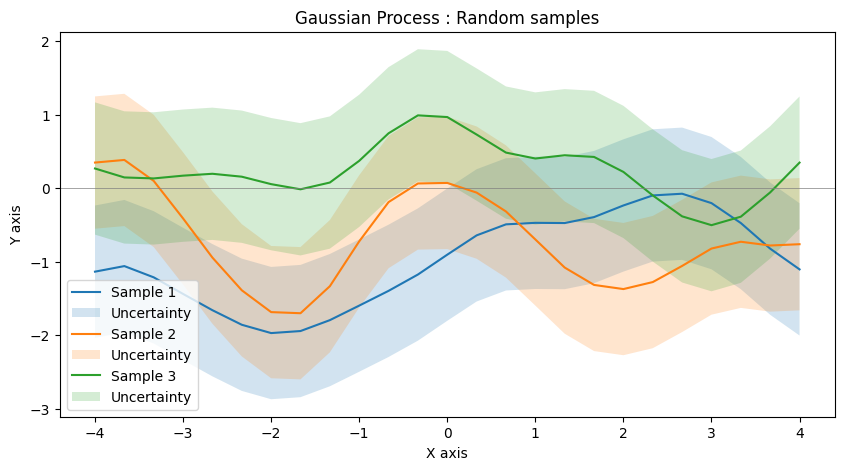

In [26]:
GP.plot_random_sample(25, 3)

In [27]:
npoints = np.linspace(-3, 1, 45) # to plot the actual function
points = np.linspace(-3, 1, 4) # train points to show the model
y = points**(3) + 4*points**(2) + points - 1
ny = npoints**(3) + 4*npoints**(2) + npoints - 1

In [29]:
points, y

(array([-3.        , -1.66666667, -0.33333333,  1.        ]),
 array([ 5.        ,  3.81481481, -0.92592593,  5.        ]))

In [30]:
points.shape, y.shape

((4,), (4,))

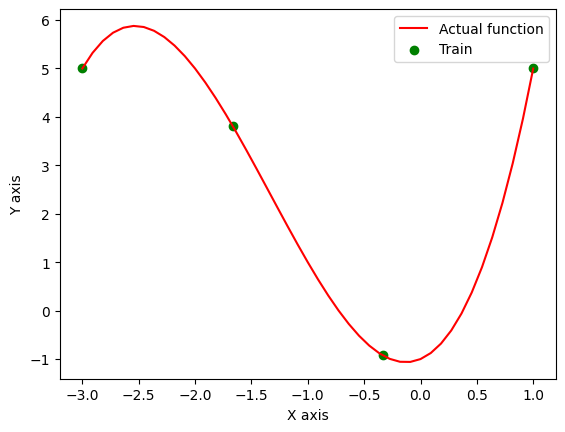

In [31]:
plt.plot(npoints, ny, 'red', label='Actual function')
plt.scatter(points, y, color='green', marker='o', label='Train')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()

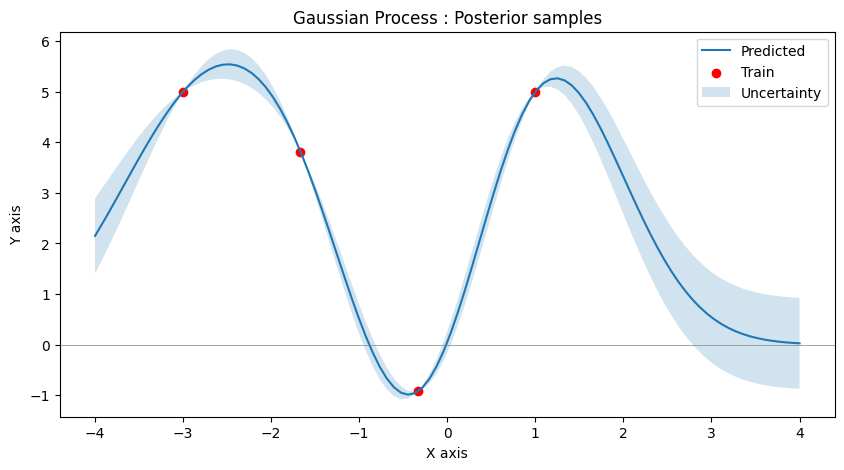

In [32]:
GP.plot_posterior_samples(points, y, N=100)
# points = np.linspace(-10, 10, 15)
# y = 40*points**2/(0.1 + points**3)
# plt.plot(points, y, 'red')